In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import requests
from PIL import Image, UnidentifiedImageError
import tensorflow as tf
import numpy as np
from PIL import Image as PILImage
from IPython.display import Image as IPImage, display

In [3]:
def load_and_preprocess_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img_resized = img.resize((224, 224))  # Resize for VGG16 input
        img_array = np.array(img_resized)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_input(img_array)  # Preprocess for VGG16
        return img_array, img
    except UnidentifiedImageError:
        print(f"Error: Unable to identify image at path: {image_path}")
    except FileNotFoundError:
        print(f"Error: File not found at path: {image_path}")
    except Exception as e:
        print(f"Error loading or processing image from path {image_path}: {e}")
    return None, None

In [4]:
def compute_gradcam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap


In [5]:
def overlay_heatmap(heatmap, img, alpha=0.4, colormap='viridis'):
    heatmap = np.uint8(255 * heatmap)
    colormap = plt.get_cmap(colormap)
    colormap_colors = colormap(np.arange(256))[:, :3]
    colormap_heatmap = colormap_colors[heatmap]
    colormap_heatmap = tf.image.resize(colormap_heatmap, (img.size[1], img.size[0]))
    overlayed_img = alpha * colormap_heatmap + (1 - alpha) * np.array(img) / 255.0
    return np.clip(overlayed_img, 0, 1)

/Users/soumyadip_iitk/PycharmProjects/<231026>_<Soumyadip>_deeploycv/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_46']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


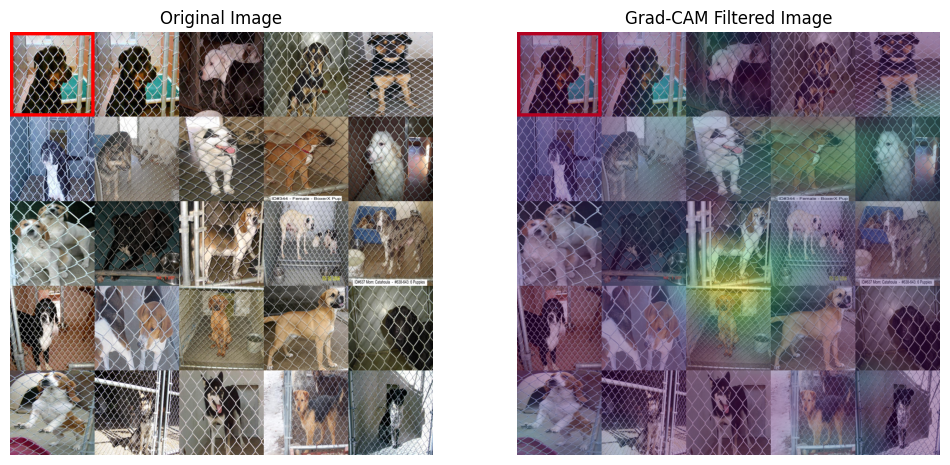

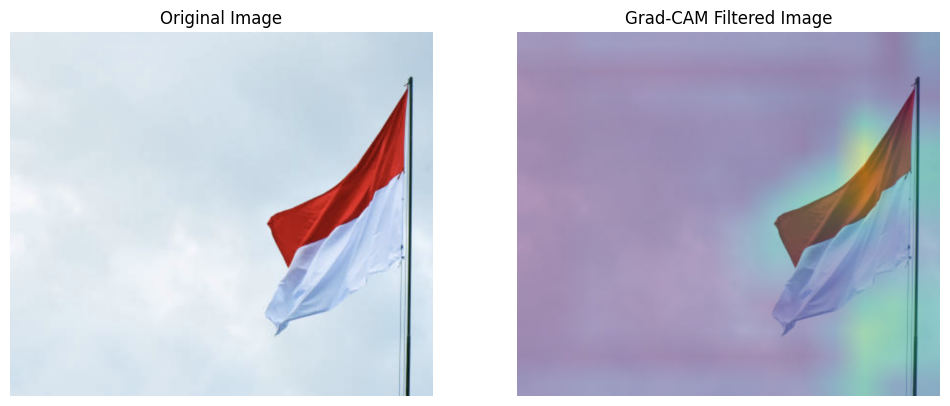

In [8]:
def gradcam_visualization(image_path, model, last_conv_layer_name):
    # Load and preprocess the image from the file path
    img_array, img = load_and_preprocess_image(image_path)
    if img_array is None or img is None:
        print(f"Skipping path: {image_path} due to invalid input.")
        return

    # Compute Grad-CAM
    heatmap = compute_gradcam(model, img_array, last_conv_layer_name)

    # Overlay the heatmap on the original image
    overlayed_img = overlay_heatmap(heatmap, img)

    # Display results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlayed_img)
    plt.title("Grad-CAM Filtered Image")
    plt.axis("off")
    plt.show()

# Paths to image files
IMAGE_PATHS = [
    "image_61.png",
    "/Users/soumyadip_iitk/PycharmProjects/<231026>_<Soumyadip>_deeploycv/untitled folder/Screenshot 2024-12-17 at 10.36.34 PM.png"
]

# Load VGG16 model
model = VGG16(weights="imagenet")

# Apply Grad-CAM visualization to each image path
for image_path in IMAGE_PATHS:
    gradcam_visualization(image_path, model, "block5_conv3")